In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

from matplotlib import projections
import matplotlib.pyplot as plt # For general plotting
import matplotlib.colors as mcol
from matplotlib.ticker import MaxNLocator

import numpy as np

from scipy.stats import multivariate_normal as mvn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F

# Utility to visualize PyTorch network and shapes
from torchsummary import summary

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)
torch.manual_seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

In [2]:
def generate_data(N, params, ax):
    n = params["mu"].shape[1]
    u = np.random.rand(N) 
    thresholds = np.cumsum(params["priors"]) # thresholds for the sample labels
    thresholds = np.insert(thresholds, 0, 0)
    
    labels = np.zeros(N) # true labels
    X = np.zeros((N, n)) # samples

    marker_shapes = '++++'
    marker_colors = 'rbgy'

    for l in params["L"]:
        # get true class labels
        indices = np.argwhere((thresholds[l-1] <= u) & (u < thresholds[l]))[:, 0]
        Nl = len(indices)
        labels[indices] = l * np.ones(Nl)

        # get samples from multivariate normal distribution and plot
        X[indices, :] = mvn.rvs(params["mu"][l-1], params["sigma"][l-1], Nl)

        ax.plot(X[indices, 0], X[indices, 1], X[indices, 2], marker_shapes[l-1] + marker_colors[l-1], label='True Class {}'.format(l))

    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.set_zlabel(r"$x_3$")
    plt.title("Q1 Data - {} Samples".format(N))

    return X, labels

In [3]:
class TwoLayerMLP(nn.Module):
    # Two-layer MLP (not really a perceptron activation function...) network class
    
    def __init__(self, input_dim, hidden_dim, C):
        super(TwoLayerMLP, self).__init__()
        # Fully connected layer WX + b mapping from input_dim (n) -> hidden_layer_dim
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        # Output layer again fully connected mapping from hidden_layer_dim -> outputs_dim (C)
        self.output_fc = nn.Linear(hidden_dim, C)
        # Log Softmax (faster and better than straight Softmax)
        # dim=1 refers to the dimension along which the softmax operation is computed
        # In this case computing probabilities across dim 1, i.e., along classes at output layer
        self.log_softmax = nn.LogSoftmax(dim=1) 
        
    # Don't call this function directly!! 
    # Simply pass input to model and forward(input) returns output, e.g. model(X)
    def forward(self, X):
        # X = [batch_size, input_dim (n)]
        X = self.input_fc(X)
        # Non-linear activation function, e.g. ReLU (default good choice)
        # Could also choose F.softplus(x) for smooth-ReLU, empirically worse than ReLU
        X = F.relu(X)
        # X = [batch_size, hidden_dim]
        # Connect to last layer and output 'logits'
        X = self.output_fc(X)
        # Squash logits to probabilities that sum up to 1
        y = self.log_softmax(X)
        return y

In [4]:
def model_train(model, data, labels, criterion, optimizer, num_epochs=25):
    # Apparently good practice to set this "flag" too before training
    # Does things like make sure Dropout layers are active, gradients are updated, etc.
    # Probably not a big deal for our toy network, but still worth developing good practice
    model.train()
    # Optimize the neural network
    for epoch in range(num_epochs):
        # These outputs represent the model's predicted probabilities for each class. 
        outputs = model(data)
        # Criterion computes the cross entropy loss between input and target
        loss = criterion(outputs, labels)
        # Set gradient buffers to zero explicitly before backprop
        optimizer.zero_grad()
        # Backward pass to compute the gradients through the network
        loss.backward()
        # GD step update
        optimizer.step()
        
    return model

def model_predict(model, data):
    # Similar idea to model.train(), set a flag to let network know your in "inference" mode
    model.eval()
    # Disabling gradient calculation is useful for inference, only forward pass!!
    with torch.no_grad():
        # Evaluate nn on test data and compare to true labels
        predicted_labels = model(data)
        # Back to numpy
        predicted_labels = predicted_labels.detach().numpy()

        return np.argmax(predicted_labels, 1)

In [5]:
def map_classifier(X, params):
    N = len(X)
    class_conditional_likelihoods = np.array([mvn.pdf(X, params["mu"][l-1], params["sigma"][l-1]) for l in params["L"]])
    class_priors = np.diag(params["priors"])
    class_posteriors = class_priors.dot(class_conditional_likelihoods)

    # MAP decision rule
    decisions = np.argmax(class_posteriors, axis=0) + np.ones(N)
    return decisions

In [6]:
def prob_error(decisions, labels):
    N = len(decisions)
    conf_mat = confusion_matrix(decisions, labels)
    correct_sample_count = np.sum(np.diag(conf_mat))
    prob_error = 1 - correct_sample_count / N

    return prob_error

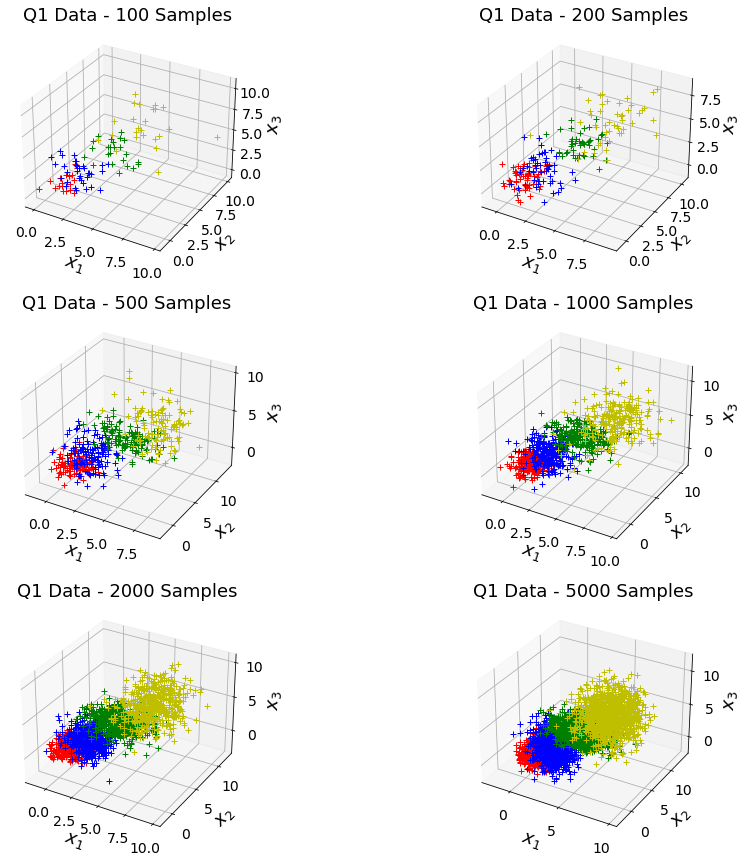

In [7]:
%matplotlib inline

params = {}
mu = np.array([[1, 1, 1], [2, 2, 2], [4, 4, 4], [6, 6, 6]])
sigma = np.array([[[0.5, 0, 0], [0, 1, 0], [0, 0, 0.5]], 
                  [[1, 0, 0], [0, 1, 0], [0, 0, 2]], 
                  [[2, 0, 0], [0, 1, 0], [0, 0, 1]], 
                  [[2, 0, 0], [0, 4, 0], [0, 0, 3]]])
priors = np.array([0.25, 0.25, 0.25, 0.25])
L = np.array([1, 2, 3, 4])

params["mu"] = mu
params["sigma"] = sigma
params["priors"] = priors
params["L"] = L

fig_samples = plt.figure(figsize=(15, 15))

# Generate data
x_train = []
y_train = []
N_train = np.array([100, 200, 500, 1000, 2000, 5000])
for i in range(len(N_train)):
    ax = fig_samples.add_subplot(3, 2, i+1, projection='3d')
    x, y = generate_data(N_train[i], params, ax)
    x_train.append(x)
    y_train.append(y)

Initial error: 0.15683000000000002


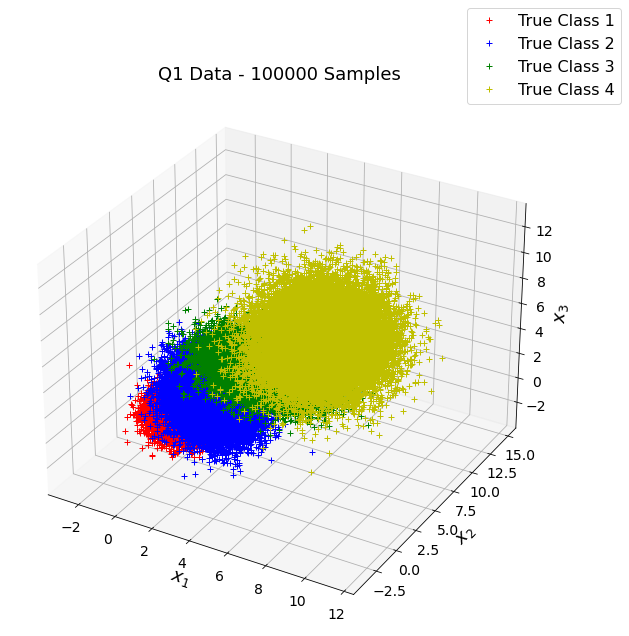

In [8]:
%matplotlib inline

handles, labels = fig_samples.get_axes()[0].get_legend_handles_labels()
fig_samples.legend(handles, labels, loc='lower center')

N_test = 100000
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection = '3d')
x_test, y_test = generate_data(N_test, params, ax)
fig.legend()

# Classify test data set
decisions = map_classifier(x_test, params)
initial_perror = prob_error(decisions, y_test)
print("Initial error: {}".format(initial_perror))

input_dim = x_train[0].shape[1]
output_dim = len(L)
models = []

Testing sample count: 100
Error values for valid set: 
[0.71 0.64 0.66 0.65 0.62 0.58 0.64 0.65 0.64 0.63 0.61 0.66 0.65 0.66
 0.66 0.69 0.67 0.67 0.69 0.65 0.66 0.67 0.68 0.66 0.64 0.69 0.69 0.7
 0.7  0.68 0.71 0.68 0.71 0.7  0.68 0.73 0.69 0.7  0.68 0.69 0.67 0.68
 0.71 0.7  0.72 0.69 0.7  0.71 0.74 0.7  0.74 0.75 0.71 0.74 0.78 0.74
 0.72 0.72 0.74 0.71 0.73 0.75 0.74 0.73 0.75 0.73 0.77 0.77 0.73 0.77
 0.79 0.77 0.76 0.77 0.74 0.76 0.78 0.74 0.78 0.76 0.79 0.77 0.75 0.75
 0.79 0.77 0.8  0.78 0.78 0.76 0.81 0.81 0.78 0.81 0.77 0.77 0.79 0.79
 0.75 0.79]
The optimal perceptron count for 100 samples is: 6
Testing sample count: 200
Error values for valid set: 
[0.8   0.8   0.695 0.765 0.715 0.75  0.74  0.785 0.765 0.805 0.785 0.795
 0.78  0.78  0.79  0.79  0.79  0.81  0.81  0.795 0.795 0.82  0.83  0.79
 0.805 0.81  0.865 0.81  0.825 0.835 0.82  0.815 0.84  0.84  0.83  0.845
 0.835 0.83  0.845 0.85  0.855 0.85  0.86  0.875 0.855 0.855 0.83  0.845
 0.87  0.835 0.855 0.845 0.84  0.875 0.8

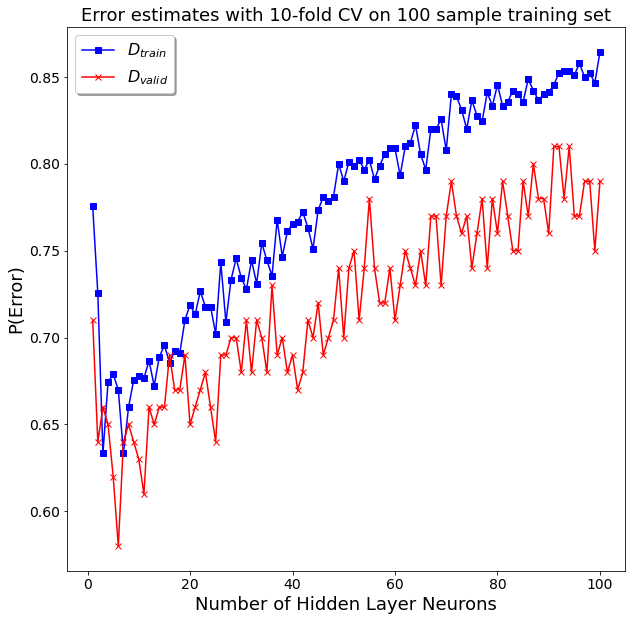

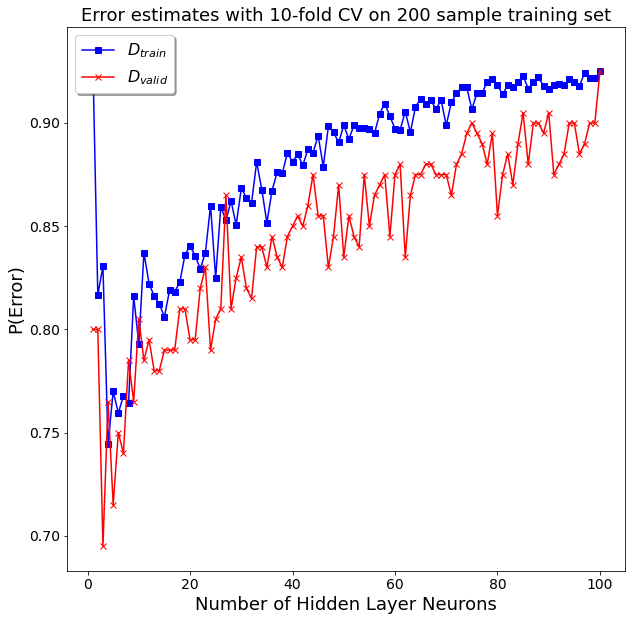

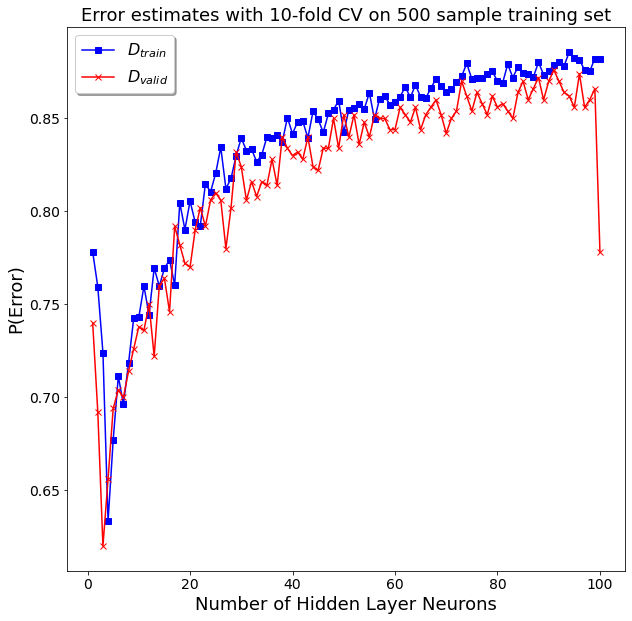

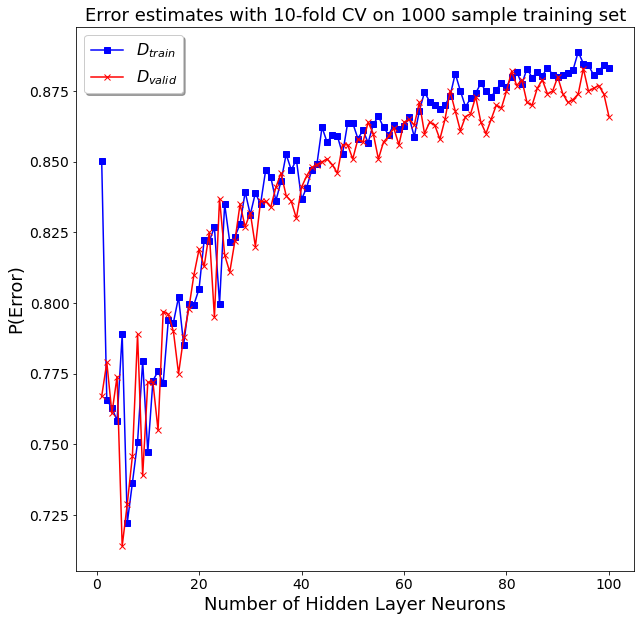

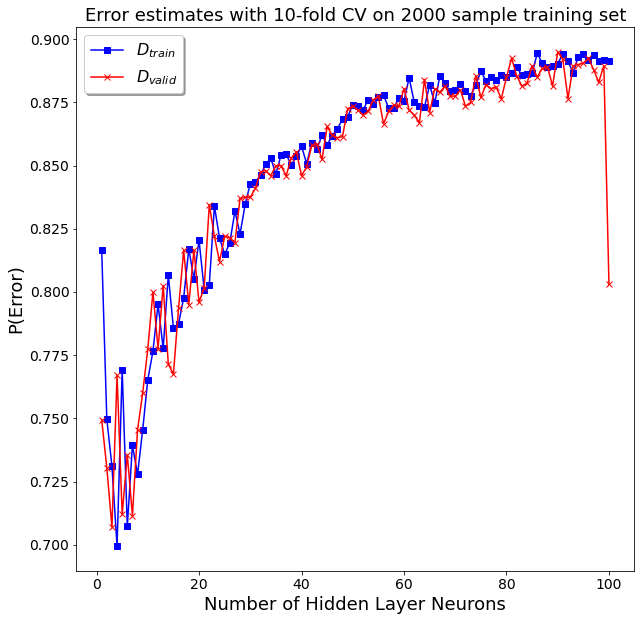

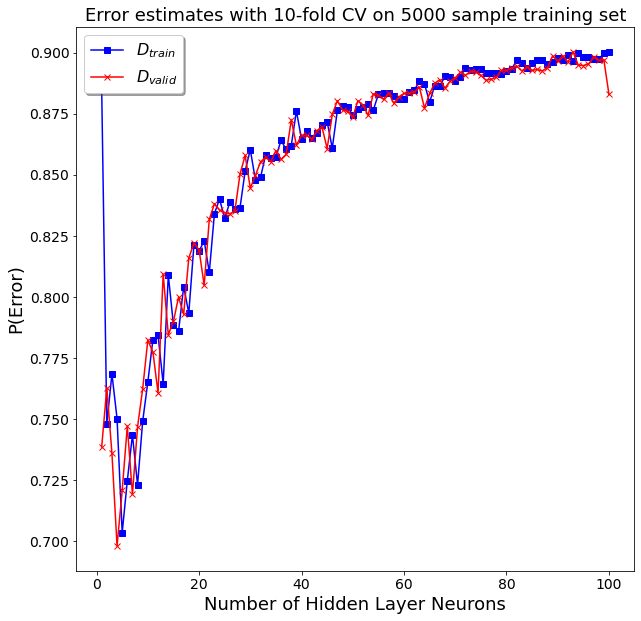

In [9]:
# Train the models
for i in range(len(N_train)):
    print(f"Testing sample count: {N_train[i]}")
    perceps = np.arange(1, 101, 1)
    K = 10

    # Partition the dataset into K approximately-equal-sized partitions
    kf = KFold(n_splits=K, shuffle=True) 

    # Allocate space for CV
    err_valid_mk = np.empty((len(perceps), K)) 
    err_train_mk = np.empty((len(perceps), K))

    for p_num in range(len(perceps)):
        k = 0
        for train_indices, valid_indices in kf.split(x_train[i]):
            # Extract the training and validation sets from the K-fold split
            x_train_k = x_train[i][train_indices]
            y_train_k = y_train[i][train_indices]
            x_valid_k = x_train[i][valid_indices]
            y_valid_k = y_train[i][valid_indices]

            # Train model parameters
            model = TwoLayerMLP(input_dim, perceps[p_num], output_dim)
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            criterion = nn.CrossEntropyLoss()
            num_epochs = 100
            x_tensor = torch.FloatTensor(x_train_k)
            y_tensor = torch.LongTensor(y_train_k) - 1
            model = model_train(model, x_tensor, y_tensor, criterion, optimizer, num_epochs=num_epochs)

            # Make predicitions on both datasets
            x_train_tensor = torch.FloatTensor(x_train_k)
            x_valid_tensor = torch.FloatTensor(x_valid_k)
            Z_train = model_predict(model, x_train_tensor)
            Z_valid = model_predict(model, x_valid_tensor)

            # Record error probs for both datasets
            err_train_mk[p_num, k] = prob_error(Z_train, y_train_k)
            err_valid_mk[p_num - 1, k] = prob_error(Z_valid, y_valid_k)
            k += 1

    # Compute the average loss for that model
    err_train_m = np.mean(err_train_mk, axis=1) # Model average CV loss over folds
    err_valid_m = np.mean(err_valid_mk, axis=1) 
    print("Error values for valid set: ")
    print(err_valid_m)

    optimal_percep = perceps[np.argmin(err_valid_m)]
    print("The optimal perceptron count for {} samples is: {}".format(N_train[i], optimal_percep))

    # Plot error vs degree
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(perceps, err_train_m, color="b", marker="s", label=r"$D_{train}$")
    ax.plot(perceps, err_valid_m, color="r", marker="x", label=r"$D_{valid}$")
    ax.legend(loc='upper left', shadow=True)
    plt.xlabel("Number of Hidden Layer Neurons")
    plt.ylabel("P(Error)")
    plt.title("Error estimates with {}-fold CV on {} sample training set".format(K, N_train[i]))

    # Train model parameters with optimal perceptron count
    model = TwoLayerMLP(input_dim, optimal_percep, output_dim)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    num_epochs = 100
    x_tensor = torch.FloatTensor(x_train[i])
    y_tensor = torch.LongTensor(y_train[i]) - 1
    model = model_train(model, x_tensor, y_tensor, criterion, optimizer, num_epochs=num_epochs)
    models.append(model)


p_errors = []

P(error)s for all optimal models:
[0.52929, 0.99561, 0.7161299999999999, 0.73368, 0.77185, 0.68422]


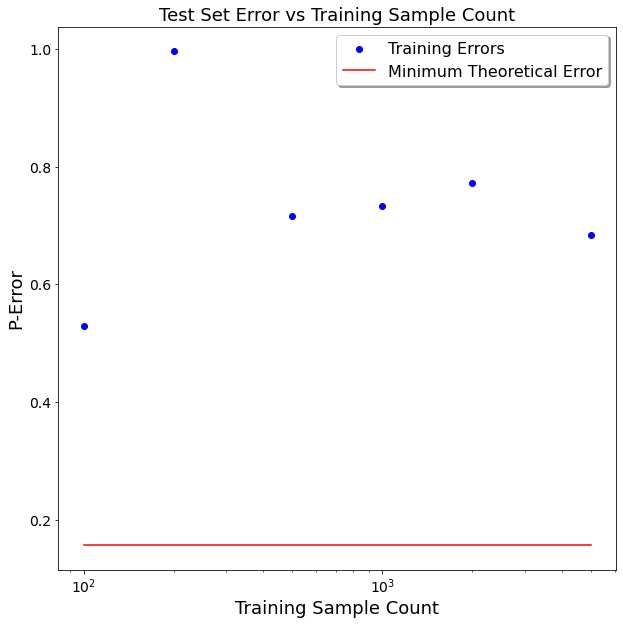

In [10]:
# Test model perfomance
for model in models:
    x_tensor = torch.FloatTensor(x_test)
    Z = model_predict(model, x_tensor)

    # Record error probs for both datasets
    perror = prob_error(Z, y_test)
    p_errors.append(perror)

print("P(error)s for all optimal models:")
print(p_errors)

# Plot error vs num samples
fig = plt.figure(figsize=(10, 10))
error_line = initial_perror*np.ones(len(N_train))
plt.scatter(N_train, p_errors, color="b", marker="o", label="Training Errors")
plt.plot(N_train, error_line, color="r", label="Minimum Theoretical Error")
plt.legend(loc='upper right', shadow=True)
plt.xlabel("Training Sample Count")
plt.ylabel("P-Error")
plt.xscale("log")
plt.title("Test Set Error vs Training Sample Count")
plt.show()